Chaining: Parametric To Inversion
=================================

This script chains two searches to fit `Interferometer` data of a 'galaxy-scale' strong lens with a model where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllExponential`.

The two searches break down as follows:

 1) Model the source galaxy using a parametric `EllSersic` and lens galaxy mass as an `EllIsothermal`.
 2) Models the source galaxy using an `Inversion` and lens galaxy mass as an `EllIsothermal`.

__Why Chain?__

There are a number of benefits of chaining a parametric source model and `Inversion`, as opposed to fitting the
`Inversion` in one search:

 - Parametric sources are computationally faster to fit. Therefore, even though the `EllSersic` has more
 parameters for the search to fit than an `Inversion`, the model-fit is faster overall.

 - `Inversion`'s often go to unphysical solutions where the mass model goes to high / low normalization_list and the source
 is reconstructed as a demagnified version of the image. (see Chapter 4, tutorial 6 for a complete description of
 this effect). This does not occur for a parametric source, therefore the mass model can be initialized using a
 parametric source, which sets up the search which fits an `Inversion` so as to not sample these unphysical solutions.

 - The `positions utils` feature can be used to further ensure these unphysical solutions do not bias the model-fit.
 positions util use the maximum log likelihood mass model of the first search to determine the image-plane position of
 the lensed source. In the second search, we then require that a mass model must trace these positions within a threshold
 arc-secoond value of one another in the source-plane, removing these unphysical solutions.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
from utils import fitutil as af
import utils as al
import utils.plot as aplt
import numpy as np

/workspace
Working Directory has been set to `/workspace`


2021-10-13 16:57:26,649 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/fitutil/config
2021-10-13 16:57:26,695 - confutil.conf - WARNING - No configuration found at path /workspace/config


2021-10-13 16:57:26,746 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/galaxyutil/config
2021-10-13 16:57:26,808 - confutil.conf - WARNING - No configuration found at path /workspace/config
2021-10-13 16:57:26,830 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/config
2021-10-13 16:57:26,894 - confutil.conf - WARNING - No configuration found at path /workspace/config


__Dataset + Masking__ 

Load, plot and mask the `Interferometer` data.

/usr/local/lib/python3.9/site-packages/pynufft/linalg/nufft_cpu.py:381: ComplexWarning: Casting complex values to real discards the imaginary part
  xx.ravel()[self.NdCPUorder * self.batch + bat] = k.ravel()[


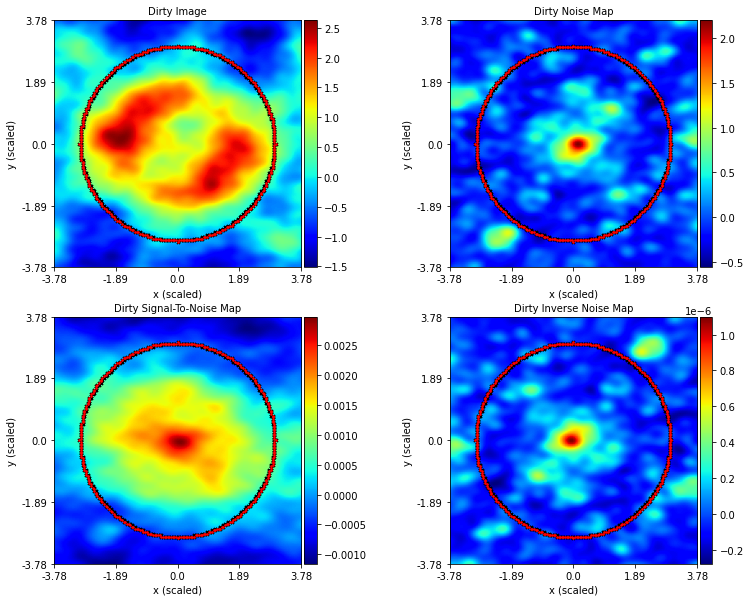

In [2]:
real_space_mask = al.Mask2D.circular(
    shape_native=(151, 151), pixel_scales=0.05, radius=3.0
)

dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "interferometer", dataset_name)

interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
    real_space_mask=real_space_mask,
)
interferometer = interferometer.apply_settings(
    settings=al.SettingsInterferometer(transformer_class=al.TransformerNUFFT)
)

interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()
interferometer_plotter.subplot_dirty_images()

__Model (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear` [7 parameters].
 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=13.

In [3]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search + Analysis + Model Fit (Search 1)__

We now create the non-linear search, analysis and perform the model-fit using this model.

You may wish to inspect the results of the search 1 model-fit to ensure a fast non-linear search has been provided that 
provides a reasonably accurate lens model.

In [ ]:
search = af.DynestyStatic(
    path_prefix=path.join("interferometer", "chaining", "parametric_to_inversion"),
    name="search[1]__parametric",
    unique_tag=dataset_name,
    nlive=50,
)

analysis = al.AnalysisInterferometer(dataset=interferometer)

result_1 = search.fit(model=model, analysis=analysis)

__Model (Search 2)__

We use the results of search 1 to create the lens model fitted in search 2, where:

 - The lens galaxy's total mass distribution is again an `EllIsothermal` and `ExternalShear` [7 parameters].
 - The source-galaxy's light uses a `VoronoiMagnification` pixelization [2 parameters].
 - This pixelization is regularized using a `Constant` scheme which smooths every source pixel equally [1 parameter]. 

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=10.

The priors of the majority of the `EllIsothermal` and `ExternalShear` initialized using the results of search 1.

The term `model` below passes the source model as model-components that are to be fitted for by the 
non-linear search. We pass the `lens` as a `model`, so that we can use the mass model inferred by search 1. The source
does not use any priors from the result of search 1.

In [ ]:
lens = result_1.model.galaxies.lens
source = af.Model(
    al.Galaxy,
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification,
    regularization=al.reg.Constant,
)
model = af.Collection(galaxies=af.Collection(lens=lens, source=source))
# %%
'''
__Analysis + Positions__

In this example we use the `auto_positions` feature, where the positions correspond to the (y,x) locations of the 
lensed source's multiple images. When a model-fit uses positions, it requires them to trace within a threshold value of 
one another for every mass model sampled by the non-linear search. If they do not, the model is discarded and resampled. 

The setting below leads to the following behaviour for searches 1 and 2:

 Search 1) No positions are input into the `AnalysisInterferometer`, therefore positions are not used.

 Search 2) Positions are again not manually input in the `AnalysisInterferometer` object. However, because the result of
 search 1 is, alongside the auto_positions settings, the maximum log likelihood model of search 1 is used to
 compute the positions of the lensed source galaxy as well as the threshold within which they trace to one another. 

This threshold is multiplied by the `auto_positions_factor` to ensure it is not too small (and thus does not remove 
plausible mass models). If, after this multiplication, the threshold is below the `auto_positions_minimum_threshold`, 
it is rounded up to this minimum value.
'''

In [ ]:
settings_lens = al.SettingsLens(
    positions_threshold=result_1.positions_threshold_from(
        factor=3.0, minimum_threshold=0.2
    )
)

analysis = al.AnalysisInterferometer(
    dataset=interferometer,
    positions=result_1.image_plane_multiple_image_positions,
    settings_lens=settings_lens,
)

__Search + Model-Fit__

We now create the non-linear search and perform the model-fit using this model.

In [ ]:
search = af.DynestyStatic(
    path_prefix=path.join("interferometer", "chaining", "parametric_to_inversion"),
    name="search[2]__inversion",
    unique_tag=dataset_name,
    nlive=40,
)

result_2 = search.fit(model=model, analysis=analysis)

__Wrap Up__

In this example, we passed used prior passing to initialize an `EllIsothermal` + `ExternalShear` lens mass model 
using a parametric source and pass this model to a second search which modeled the source using an `Inversion`. 

This was more computationally efficient than just fitting the `Inversion` by itself and helped to ensure that the 
`Inversion` did not go to an unphysical mass model solution which reconstructs the source as a demagnified version
of the lensed image.

__Pipelines__

Advanced search chaining uses `pipelines` that chain together multiple searches to perform complex lens modeling 
in a robust and efficient way. 

 __SLaM (Source, Light and Mass)__
 
An even more advanced approach which uses search chaining are the SLaM pipelines, which break the lens modeling 
processing into a series of fits that first perfect the source model, then the lens light model and finally the lens
mass model. 

The SLaM pipelines begin with a parametric Source pipeline, which then switches to an inversion Source pipeline, 
exploiting the chaining technique demonstrated in this example.